# Check if adding 'point' column helps!!!!!
# Check raw

# Age Groups

In [1]:
import geopandas as gp
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Point
import nafot
import time
from tqdm import tqdm, tqdm_notebook
from geopy.distance import vincenty
plt.style.use('ggplot')
%matplotlib inline

### Location and CDR data

Get the statistical area GeoDataFrame

In [14]:
gdf = nafot.gdf.copy()

Loading location data

In [17]:
# loc_data_sm = pd.read_csv('../../Data/new samples/with stat area/sample_00with_stat.csv')

# # Remove records without stat area
# loc_data_sm.dropna(inplace=True)

Getting a sample

In [22]:
# imsi_sm = np.random.choice(pd.unique(loc_data_sm.imsi), 1000, replace=False)
# loc_data_sample = loc_data_sm[loc_data_sm.imsi.isin(imsi_sm)].copy()

Adding yeshuv column

In [23]:
# loc_data_sample['yeshuv'] = loc_data_sample.stat_area_id.apply(lambda x: gdf.SEMEL_YISH.loc[x])

Saving the sample for later

In [24]:
# loc_data_sample.to_csv('../../data/1000_users_sm.csv', index=False)

Loading the sample

In [3]:
loc_data_sm = pd.read_csv('../../data/1000_users_sm.csv')

### School location data

In [9]:
# edu_locations = pd.read_csv('./data/schools_edited.csv', encoding='windows-1255')
# # Unwanted columns
# edu_locations.drop(['SETL_CODE', 'LATIN_NAME', 'USG_CODE' ,'E_ORD', 'N_ORD'],axis=1, inplace=True)

Converting to WGS

In [10]:
# edu_locations['lonlat'] = edu_locations.apply(lambda row: \
#                                                  nafot.coordinates_conversion.itm_to_wgs(row.X, row.Y),axis=1)
# edu_locations['longtitude'] = edu_locations.lonlat.apply(lambda x: x[0])
# edu_locations['latitude'] = edu_locations.lonlat.apply(lambda x: x[1])
# edu_locations.drop('lonlat', axis=1, inplace=True)

Adding stat_area and yeshuv columns

In [11]:
# edu_locations = nafot.stat_areas.add_stat_area_column(edu_locations, path=False)

In [12]:
# Drop rows without stat_area (there will be no recrods form there)
# edu_locations = edu_locations[~edu_locations.stat_area_id.isnull()]

In [13]:
# edu_locations['yeshuv'] = edu_locations.stat_area_id.apply(lambda x: gdf.SEMEL_YISH.loc[x])

Saving edu_locations

In [14]:
# edu_locations.to_csv('./data/edu_locations.csv', index=False)

Loading edu_locations

In [4]:
edu_locations = pd.read_csv('../data/edu_locations.csv', encoding='windows-1255')

In [5]:
edu_locations['latlon'] = list(zip(edu_locations['latitude'], edu_locations['longtitude']))

In [6]:
edu_locations.head()

,UNIQ_ID,NAME,category,sub_category,X,Y,longtitude,latitude,stat_area_id,yeshuv,latlon
0,54452836,האוניברסיטה - הפתוחה באר שבע,university,NaN,179507.7353,572444.8784,34.785158,31.242956,9000611.0,9000,"(31.242955582477254, 34.78515791756074)"
1,54450440,בית ספר - בן גוריון,school,elementary school,181916.2177,575383.5957,34.810330,31.269540,9000642.0,9000,"(31.26953971249547, 34.810329831386596)"
2,54450456,גן ילדים - גן המעפילים,kindergarten,NaN,181522.1307,573107.7254,34.806278,31.249001,9000631.0,9000,"(31.249001005653078, 34.806278095118444)"
3,54448309,בית ספר - שקמים,school,elementary school,161408.5068,603624.8576,34.593355,31.523391,10312.0,1031,"(31.52339142326771, 34.593354579416484)"
4,64763939,בית ספר - שקמים מעוז,school,elementary school,161285.9086,604728.5040,34.591999,31.533338,10315.0,1031,"(31.53333822794813, 34.59199891305953)"


Filtering schools only

In [7]:
school_locations = edu_locations[edu_locations.category == 'school'].copy()

In [8]:
school_locations.sub_category.value_counts()

elementary school    1150
religious school      570
high school           324
special school        202
middle school         143
boarding school        64
Name: sub_category, dtype: int64

In [9]:
school_locations.head()

,UNIQ_ID,NAME,category,sub_category,X,Y,longtitude,latitude,stat_area_id,yeshuv,latlon
1,54450440,בית ספר - בן גוריון,school,elementary school,181916.2177,575383.5957,34.810330,31.269540,9000642.0,9000,"(31.26953971249547, 34.810329831386596)"
3,54448309,בית ספר - שקמים,school,elementary school,161408.5068,603624.8576,34.593355,31.523391,10312.0,1031,"(31.52339142326771, 34.593354579416484)"
4,64763939,בית ספר - שקמים מעוז,school,elementary school,161285.9086,604728.5040,34.591999,31.533338,10315.0,1031,"(31.53333822794813, 34.59199891305953)"
6,54447717,"תיכון מ""מ חדש ע""ש א' ליהמן",school,high school,203343.7023,553165.3997,35.035678,31.069641,22007.0,2200,"(31.06964144356668, 35.03567810531364)"
7,54447940,חווה למדעי הסביבה והחקלאות,school,special school,202746.2680,554040.5973,35.029404,31.077527,220012.0,2200,"(31.077526838001987, 35.02940359832676)"


### Finding users near schools

Checking if point is near school

In [10]:
def is_near_school(lat, lon, thresh, yeshuv=None, return_school_id=False):
    if yeshuv:
        schools = school_locations[school_locations.yeshuv == yeshuv].copy()
        if schools.empty:
            return None if return_school_id else False
    else:
        schools = school_locations

    # Get a vector where True is near a school and False is not
    nearby_schools = schools.latlon.apply(lambda latlon: vincenty((lat, lon), (latlon)).meters < thresh)
    
    # Is the point near a school
    near_school =  nearby_schools.any()
    
    if near_school:
        return schools.UNIQ_ID[nearby_schools].values[0] if return_school_id else True

    else:
        return None if return_school_id else False

Calculating distance from home

In [11]:
def get_dist_from_home(row):
    if not np.isnan(row.home_center).any():
        return row.home_center.distance(Point(row.longtitude, row.latitude))

def get_dist_from_home2(row):
    if not np.isnan(row.home_center).any():
        return vincenty((row.latitude, row.longtitude), (row.home_center.y, row.home_center.x)).meters

Getting only signals in weekdays

In [12]:
weekends_dates = ['2012-11-30', '2012-12-01', '2012-12-07', '2012-12-08', '2012-12-14', '2012-12-15', '2012-12-21',
                  '2012-12-22', '2012-12-28', '2012-12-29', '2013-01-04', '2013-01-05', '2013-01-11', '2013-01-12',
                  '2013-01-18', '2013-01-19', '2013-01-25', '2013-01-26' '2013-02-01', '2013-02-02']

loc_data_sm = loc_data_sm[~loc_data_sm.date_stamp.isin(weekends_dates)].copy()

Add home stat area data

In [15]:
# Get home data
home_data = pd.read_csv('../../Data/new_samples/home_area/home_area_data_all_updated.csv')    
home_data.set_index('imsi', inplace=True)
home_data.home_stat_area = home_data.home_stat_area.apply(lambda x: float(x) if x != 'NotDetermined' else x)

# Adding the centroid of the home stat_area
home_data = home_data.merge(pd.DataFrame(gdf.geometry.centroid), how='left', left_on='home_stat_area', right_index=True)
home_data.columns = ['home_stat_area', 'home_center']

# Add home stat area and center columns
loc_data_sm = loc_data_sm.merge(home_data, how='left', left_on='imsi', right_index=True)

# Remove users without home stat area
loc_data_sm = loc_data_sm[loc_data_sm.home_stat_area != 'NotDetermined'].copy()

Getting only signals between 9:00-11:00

In [16]:
morning_hours = range(18, 22)
loc_data_morning = loc_data_sm[loc_data_sm.halfhouridx.isin(morning_hours)].copy()
loc_data_morning.shape

(1156904, 10)

Calculate distance from home - only for the analysis

In [17]:
tqdm_notebook().pandas()
print(loc_data_morning.shape)
loc_data_morning['dist_from_home'] = loc_data_morning.progress_apply(get_dist_from_home2, axis=1)

A Jupyter Widget


(1156904, 10)


A Jupyter Widget

Add is_near_school column (without adding school id)

In [19]:
tqdm().pandas()
loc_data_morning['is_near_school'] = loc_data_morning.progress_apply(lambda row:\
                                                                     is_near_school(row.latitude, row.longtitude, 200, row.yeshuv), axis=1)

0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████| 1156904/1156904 [45:33<00:00, 423.17it/s]


Add school_id column

In [20]:
tqdm_notebook().pandas()
loc_data_morning['school_id'] = loc_data_morning.progress_apply(lambda row:\
                                                                     is_near_school(row.latitude, row.longtitude, 200, row.yeshuv), axis=1)

A Jupyter Widget

A Jupyter Widget

Add is_near_school column - by school id column

In [21]:
loc_data_morning['is_near_school'] = ~loc_data_morning.school_id.isnull()

Find users near schools

In [22]:
# Group by imsi
gb_imsi_mor = loc_data_morning.groupby('imsi')

# Filter users that where near school at least 80% of the time
users_near_school = np.array(sorted(pd.unique(loc_data_morning.imsi)))\
                                        [np.where((gb_imsi_mor.is_near_school.sum() / gb_imsi_mor.is_near_school.count()) > 0.8)[0]]
    
print('number of users near school: {}'.format(users_near_school.size))
print(datetime.now())

number of users near school: 773


NameError: name 'datetime' is not defined

Get school_id for each user


In [31]:
users_school_id = gb_imsi_mor['school_id'].agg(lambda x: x.value_counts(dropna=False).index[0])
# Filter only users near schools
users_school_id = users_school_id[users_near_school]

Create imsi df

In [18]:
gb_imsi = loc_data_sm.groupby('imsi')

# Count the number of distinct stat_areas
imsi_df = gb_imsi[['stat_area_id']].nunique()
imsi_df.columns = ['distinct_stat_areas']

# Count the number of distinct stat_areas per day
imsi_df['distinct_stat_areas_per_day'] = loc_data_sm.groupby(['imsi', 'date_stamp'])\
                                                        [['stat_area_id']].nunique().reset_index().groupby('imsi').mean()
    
# Count the number of distinct yeshuvim
imsi_df['distinct_yeshuvim'] = gb_imsi[['yeshuv']].nunique()

# Count the number of distinct yeshuvim per day
imsi_df['distinct_yeshuvim_per_day'] = loc_data_sm.groupby(['imsi', 'date_stamp'])\
                                                        [['yeshuv']].nunique().reset_index().groupby('imsi').mean()

# Add average distance from home per day
imsi_df['avg_dist_from_home'] = loc_data_sm.groupby(['imsi', 'date_stamp'])\
                                                        [['dist_from_home']].mean().reset_index().groupby('imsi').mean()

# Add average of max distance from home
imsi_df['max_dist_from_home'] = loc_data_sm.groupby(['imsi', 'date_stamp'])\
                                                        [['dist_from_home']].max().reset_index().groupby('imsi').mean()

# True if the user is near a school > 80% of the time 
imsi_df['is_near_school'] = imsi_df.index.isin(users_near_school)

# Add school_id column
imsi_df['school_id'] = imsi_df.apply(lambda row:\
                                     users_school_id.loc[row.name] if row.name in users_school_id.index else None, axis=1)

# Add school type column
imsi_df['school_type'] = imsi_df.school_id.apply(lambda school_id:\
                                                 school_locations[school_locations.UNIQ_ID == school_id].sub_category.values[0]\
                                                if not np.isnan(school_id) else '_not_school')

KeyError: "Columns not found: 'dist_from_home'"

In [33]:
imsi_df.head()

,distinct_stat_areas,distinct_stat_areas_per_day,distinct_yeshuvim,distinct_yeshuvim_per_day,avg_dist_from_home,max_dist_from_home,is_near_school,school_id,school_type
imsi,,,,,,,,,
18560865,81,8.030303,32,4.939394,1588.103776,5411.888463,False,NaN,_not_school
118768365,130,9.657895,68,7.315789,10301.444823,17263.645033,False,NaN,_not_school
321718465,16,3.764706,1,1.000000,519.783861,2241.924091,False,NaN,_not_school
463618465,182,10.675676,42,4.810811,8838.246256,11817.992949,False,NaN,_not_school
465322565,28,3.111111,4,1.500000,4884.531913,7538.261352,False,NaN,_not_school


In [34]:
imsi_df.to_csv('./data/imsi_df.csv')

#### Distinct stat area and yeshuvim count by is_near_school

In [35]:
count_is_near = imsi_df.groupby('is_near_school')[['distinct_stat_areas_per_day', 'distinct_yeshuvim_per_day']]
count_is_near.describe()

distinct_stat_areas_per_day                                     \
                                     count      mean       std  min       25%   
is_near_school                                                                  
False                                549.0  9.038158  6.444091  1.0  4.000000   
True                                  19.0  4.963126  3.699142  1.0  2.111111   

                                              distinct_yeshuvim_per_day  \
                     50%        75%       max                     count   
is_near_school                                                            
False           7.666667  12.131579  44.52381                     549.0   
True            4.285714   6.871542  13.06250                      19.0   

                                                                                
                    mean       std  min       25%       50%       75%      max  
is_near_school                                                                  
False           4.214316  3.322730  1.0  1.812500  3.236842  5.555556  21.7500  
True            2.005803  1.468052  1.0  1.212353  1.692308  1.934524   7.4375

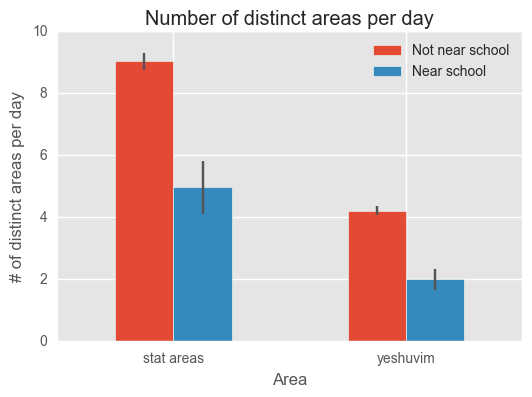

In [36]:
# Get the number of users
n = count_is_near.count()['distinct_stat_areas_per_day'].values

# Distinct stat areas per day
count_is_near.mean().T.plot(kind='bar', yerr=count_is_near.std().T/np.sqrt(n))
plt.title('Number of distinct areas per day')
plt.xlabel('Area')
plt.ylabel('# of distinct areas per day')
plt.xticks(np.arange(2), ['stat areas', 'yeshuvim'], rotation='horizontal')
plt.legend(['Not near school', 'Near school'])
plt.show()

# Distinct yeshuvim per day
# yesuvim_is_near.mean()['distinct_yeshuvim_per_day'].plot(kind='bar', yerr=yesuvim_is_near.std()['distinct_yeshuvim_per_day']/np.sqrt(n))
# plt.title('Distinct yeshuvim per day')
# plt.xlabel('Is near school')
# plt.ylabel('# of distinct yeshuvim per day')
# plt.show()

#### Distinct stat area and yeshuvim count by school_type

In [37]:
count_type = imsi_df.groupby('school_type')[['distinct_stat_areas_per_day', 'distinct_yeshuvim_per_day']]
count_type.describe()

distinct_stat_areas_per_day                                \
                                        count      mean       std       min   
school_type                                                                   
_not_school                             549.0  9.038158  6.444091  1.000000   
elementary school                         9.0  3.540127  2.752485  1.500000   
high school                               3.0  5.622963  5.347878  1.000000   
middle school                             1.0  9.583333       NaN  9.583333   
religious school                          2.0  8.674107  6.206125  4.285714   
special school                            4.0  4.659455  2.657841  2.000000   

                                                             \
                        25%       50%        75%        max   
school_type                                                   
_not_school        4.000000  7.666667  12.131579  44.523810   
elementary school  1.812500  2.411765   4.625000   9.923077   
high school        2.694444  4.388889   7.934444  11.480000   
middle school      9.583333  9.583333   9.583333   9.583333   
religious school   6.479911  8.674107  10.868304  13.062500   
special school     2.671053  4.492823   6.481225   7.652174   

                  distinct_yeshuvim_per_day                                \
                                      count      mean       std       min   
school_type                                                                 
_not_school                           549.0  4.214316  3.322730  1.000000   
elementary school                       9.0  1.673038  0.778241  1.000000   
high school                             3.0  1.238519  0.285980  1.000000   
middle school                           1.0  1.833333       NaN  1.833333   
religious school                        2.0  4.736607  3.819639  2.035714   
special school                          4.0  2.007703  0.704175  1.470588   

                                                            
                        25%       50%       75%        max  
school_type                                                 
_not_school        1.812500  3.236842  5.555556  21.750000  
elementary school  1.000000  1.500000  1.718750   3.131579  
high school        1.080000  1.160000  1.357778   1.555556  
middle school      1.833333  1.833333  1.833333   1.833333  
religious school   3.386161  4.736607  6.087054   7.437500  
special school     1.663102  1.758373  2.102975   3.043478

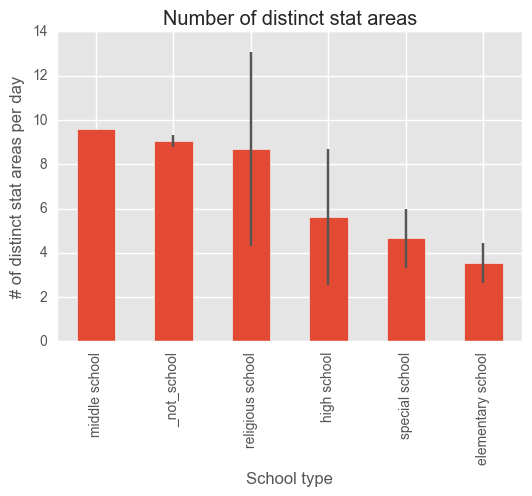

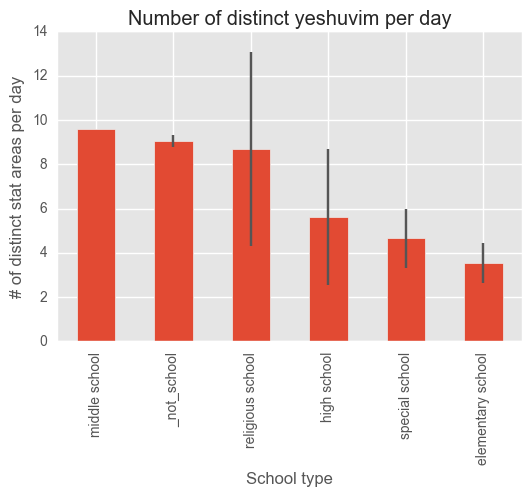

In [38]:
# Get the number of users
n = count_type.count()['distinct_stat_areas_per_day'].values

# Distinct stat areas per day
count_type.mean()['distinct_stat_areas_per_day'].sort_values(ascending=False).plot(kind='bar', yerr=count_type.std()['distinct_stat_areas_per_day']/np.sqrt(n))
plt.title('Number of distinct stat areas')
plt.xlabel('School type')
plt.ylabel('# of distinct stat areas per day')
plt.show()

# Distinct yeshuvim per day
count_type.mean()['distinct_stat_areas_per_day'].sort_values(ascending=False).plot(kind='bar', yerr=count_type.std()['distinct_stat_areas_per_day']/np.sqrt(n))
plt.title('Number of distinct yeshuvim per day')
plt.xlabel('School type')
plt.ylabel('# of distinct stat areas per day')
plt.show()

#### Average and max daily distance from home by is_near_school

In [39]:
dist_is_near = imsi_df.groupby('is_near_school')[['avg_dist_from_home', 'max_dist_from_home']]
dist_is_near.describe()

avg_dist_from_home                                       \
                            count         mean          std        min   
is_near_school                                                           
False                       474.0  7339.436088  7970.871780  81.476152   
True                         17.0  3103.833610  4114.395794  48.816837   

                                                                     \
                        25%          50%          75%           max   
is_near_school                                                        
False           1855.731685  4472.477401  9774.662284  49927.728905   
True             659.406198  1698.976287  3906.522453  15459.918224   

               max_dist_from_home                                          \
                            count          mean           std         min   
is_near_school                                                              
False                       474.0  12996.857512  11236.120025  273.455070   
True                         17.0   5216.077798   5729.892107   68.406304   

                                                                      
                        25%          50%           75%           max  
is_near_school                                                        
False           5005.299085  9732.347162  17567.087508  61690.857906  
True            1939.877181  3496.380417   6302.275410  23585.054021

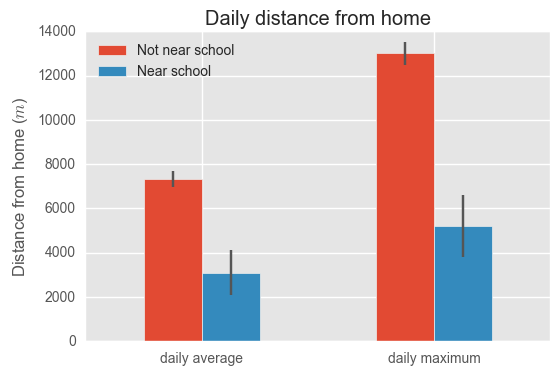

In [51]:
# Get the number of users
n = dist_is_near.count()['avg_dist_from_home'].values

# Average daily distance
dist_is_near.mean().T.plot(kind='bar', yerr=dist_is_near.std().T/np.sqrt(n))
plt.title('Daily distance from home')
plt.ylabel('Distance from home ($m$)')
plt.xticks(np.arange(2), ['daily average', 'daily maximum'], rotation='horizontal')
plt.legend(['Not near school', 'Near school'], loc='best')
plt.show()

# Max daily distance
# dist_is_near.mean()['max_dist_from_home'].plot(kind='bar', yerr=dist_is_near.std()['max_dist_from_home']/np.sqrt(n))
# plt.title('Max daily distance from home')
# plt.xlabel('Is near school')
# plt.ylabel('Max daily distance from home ($m$)')
# plt.show()

#### Average and max daily distance from home by school type

In [41]:
dist_type = imsi_df.groupby('school_type')[['avg_dist_from_home', 'max_dist_from_home']]
dist_type.describe()

avg_dist_from_home                                         \
                               count         mean          std          min   
school_type                                                                   
_not_school                    474.0  7339.436088  7970.871780    81.476152   
elementary school                7.0  1647.318388  1697.146643   169.999362   
high school                      3.0  3779.507149  5940.808912    48.816837   
middle school                    1.0  2136.377087          NaN  2136.377087   
religious school                 2.0  8579.447255  9730.455359  1698.976287   
special school                   4.0  2650.037404  1858.133032   811.780513   

                                                                         \
                           25%          50%           75%           max   
school_type                                                               
_not_school        1855.731685  4472.477401   9774.662284  49927.728905   
elementary school   361.032672  1004.469014   2748.394054   4137.906891   
high school         354.111518   659.406198   5644.852304  10630.298411   
middle school      2136.377087  2136.377087   2136.377087   2136.377087   
religious school   5139.211771  8579.447255  12019.682739  15459.918224   
special school     1869.352760  2275.655268   3056.339912   5237.058565   

                  max_dist_from_home                                           \
                               count          mean           std          min   
school_type                                                                     
_not_school                    474.0  12996.857512  11236.120025   273.455070   
elementary school                7.0   3315.948104   3222.816389   578.604688   
high school                      3.0   4672.096755   6421.626174    68.406304   
middle school                    1.0   4551.296032           NaN  4551.296032   
religious school                 2.0  13938.891293  13641.734155  4292.728565   
special school                   4.0   4754.079238   2219.911089  3403.223000   

                                                                          
                           25%           50%           75%           max  
school_type                                                               
_not_school        5005.299085   9732.347162  17567.087508  61690.857906  
elementary school   656.790917   2615.417256   4899.327914   8905.377121  
high school        1004.141743   1939.877181   6973.941980  12008.006779  
middle school      4551.296032   4551.296032   4551.296032   4551.296032  
religious school   9115.809929  13938.891293  18761.972657  23585.054021  
special school     3462.663216   3779.936865   5071.352887   8053.220223

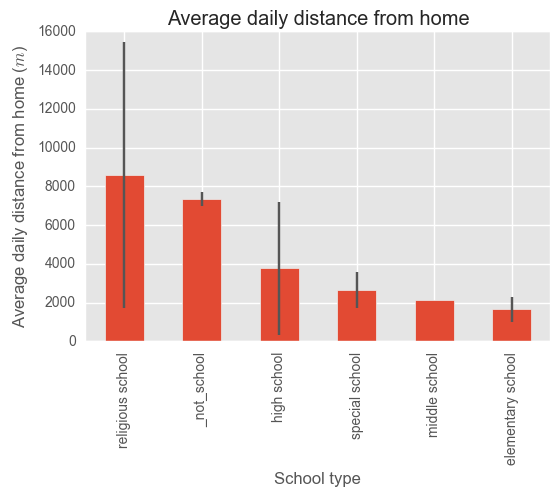

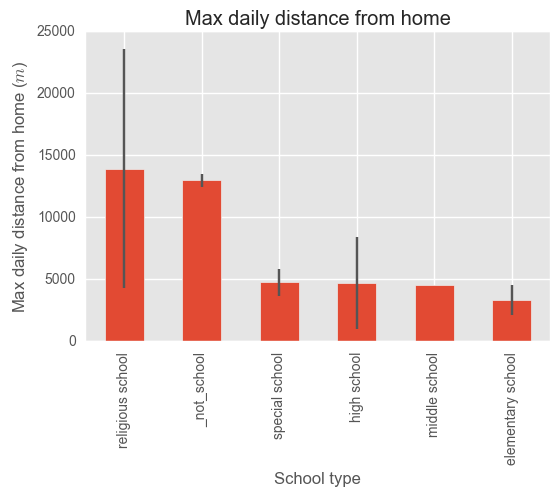

In [42]:
# Get the number of users
n = dist_type.count()['avg_dist_from_home'].values

# Distinct stat areas per day
dist_type.mean()['avg_dist_from_home'].sort_values(ascending=False).plot(kind='bar', yerr=dist_type.std()['avg_dist_from_home']/np.sqrt(n))
plt.title('Average daily distance from home')
plt.xlabel('School type')
plt.ylabel('Average daily distance from home ($m$)')
plt.show()

# Distinct yeshuvim per day
dist_type.mean()['max_dist_from_home'].sort_values(ascending=False).plot(kind='bar', yerr=dist_type.std()['max_dist_from_home']/np.sqrt(n))
plt.title('Max daily distance from home')
plt.xlabel('School type')
plt.ylabel('Max daily distance from home ($m$)')
plt.show()

In [43]:
imsi_df.head()

,distinct_stat_areas,distinct_stat_areas_per_day,distinct_yeshuvim,distinct_yeshuvim_per_day,avg_dist_from_home,max_dist_from_home,is_near_school,school_id,school_type
imsi,,,,,,,,,
18560865,81,8.030303,32,4.939394,1588.103776,5411.888463,False,NaN,_not_school
118768365,130,9.657895,68,7.315789,10301.444823,17263.645033,False,NaN,_not_school
321718465,16,3.764706,1,1.000000,519.783861,2241.924091,False,NaN,_not_school
463618465,182,10.675676,42,4.810811,8838.246256,11817.992949,False,NaN,_not_school
465322565,28,3.111111,4,1.500000,4884.531913,7538.261352,False,NaN,_not_school


In [44]:
[['distinct_stat_areas_per_day', 'max_dist_from_home']]

[['distinct_stat_areas_per_day', 'max_dist_from_home']]

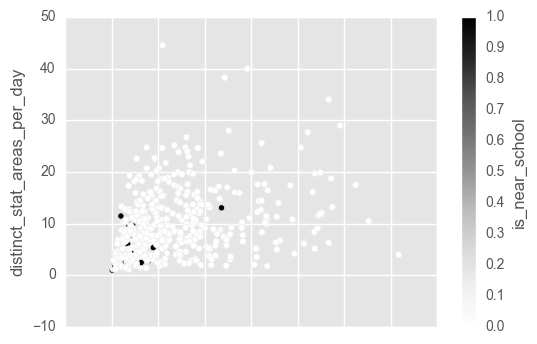

In [45]:
imsi_df.plot.scatter('max_dist_from_home', 'distinct_stat_areas_per_day', c='is_near_school')

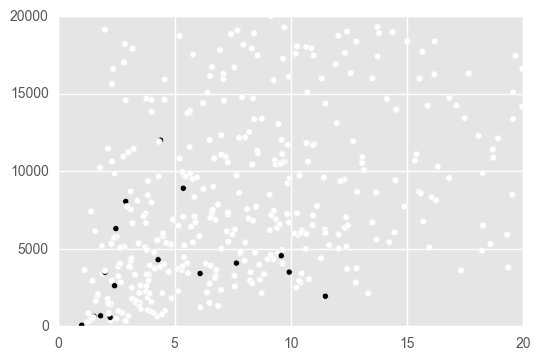

In [46]:
plt.scatter(x=imsi_df.distinct_stat_areas_per_day, y=imsi_df.max_dist_from_home, c=imsi_df.is_near_school)
plt.xlim([0,20])
plt.ylim([0,20000])
plt.show()

In [47]:
imsi_df.to_csv('./data/imsi_df.csv')